# PSI3532 - Experiência 3
Henrique Souza de Melo - 9347031

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'text.usetex':True, 'font.size':18})
from scipy import signal

#importando o filtro LMS desenvolvido
from filters import LMS

## Função para realização dos ensaios

In [2]:
def experiencia_3(item, entrada, mu, total_time, N):
    params = {
        '1':{
            'H' : np.array([1,-.5]),
            'M' : 2
        },
        '2a':{
            'H' : np.array([1]),
            'M' : 2
        },
        '2b':{
            'H' : np.array([1, -.5, .2]),
            'M' : 2
        },
        '3':{
            'H' : np.array([1,-.5]),
            'M' : 5
        }
    }
    
    H = params[item]['H']
    M = params[item]['M']
    
    if entrada == '1':
        a = 0
    elif entrada == '2':
        a = .9
    
    n = np.arange(start=0, stop=total_time, step=1)
    
    MSE = np.zeros(len(n))
    EMSE = np.zeros(len(n))
    MSD = np.zeros(len(n))
    
    sigma_u = np.sqrt(1)
    
    #calculo da autocorrelacao de x
    r_x = lambda l : a ** abs(l) * sigma_u ** 2
    
    #calculo de R_phi
    R_phi = np.zeros((M, M))
    for i in range(len(R_phi)):
        for j in range(len(R_phi)):
            R_phi[i, j] = r_x(abs(i-j))
    
    #calculo de r_dphi
    if len(H) == M:
        k = M
    elif len(H) > M:
        k = M
    else:
        k = len(H)
    r_dphi = np.zeros(M)
    for i in range(len(r_dphi)):
        r_dphi[i] += sum([(H[j] * r_x(i-j)) for j in range(k)])
        
    #calculo de W_o
    W_o = np.linalg.solve(a=R_phi, b=np.reshape([r_dphi], newshape=(M, 1)))
    W_o = W_o.flatten()
    
    for i in range(N):
        u = np.random.randn(len(n)) * sigma_u
        x = signal.lfilter(b=[np.sqrt(1 - a ** 2)], a=[1, -a], x=u)
        y = signal.lfilter(b=H, a=1, x=x)
        sigma_v = np.sqrt(.01)
        v = np.random.randn(len(n)) * sigma_v
        d = y + v #somar ruido ao y
        
        #calculo de valores teoricos apenas uma vez
        if(i == 0):
            e_o = np.zeros(len(x))
            for i in range(M, len(e_o)):
                e_o[i] = d[i] - np.dot(W_o, np.flip(x[(i - M):i]))
            sigma2_o = np.mean(np.square(e_o))
            MSE_teorico = np.ones(len(n)) * (sigma2_o + (mu * sigma2_o + np.matrix.trace(R_phi)) / 2)
            MSD_teorico = np.ones(len(n)) * ((mu * sigma2_o * M) / 2)
            EMSE_teorico = np.ones(len(n)) * ((mu * sigma2_o * np.matrix.trace(R_phi)) / 2)
        
        lms_filter = LMS(M=M, mu=mu)

        for i in range(0, len(x)):
            lms_filter.buffer(x[i], d[i])
        
        MSE += (1 / N) * np.square(lms_filter.e)
        
        deltaW = np.apply_along_axis(lambda row : (row - W_o),
                                             axis=1,
                                             arr=lms_filter.W)
        
        MSD += (1 / N) * np.sum(np.square(deltaW), axis=1)
        
        EMSE_i = np.zeros(len(x))
        for j in range(M, len(EMSE_i)):
            EMSE_i[j] = np.dot((lms_filter.W[j] - W_o), np.flip(x[(j - M):j]))
        EMSE += (1 / N) * np.square(EMSE_i)
        
    
    plt.figure(figsize=(14,10))
    plt.plot(n, MSE, n, MSE_teorico, '--', n, MSD, n, MSD_teorico, '--', n, EMSE, n, EMSE_teorico, '--')
    plt.legend(['MSE', 'MSE teórico', 'MSD', 'MSD teórico', 'EMSE', 'EMSE teórico'])
    plt.xlabel('$n$')
    plt.title('$H={H}$, $M={M}$, $a={a}$, $\mu={mu}$'.format(H=H,M=M,a=a,mu=mu))
    
    return (lms_filter, W_o)

## Realizando um ensaio

Gráfico de medidas de desempenho e coeficientes ótimos

array([ 1. , -0.5])

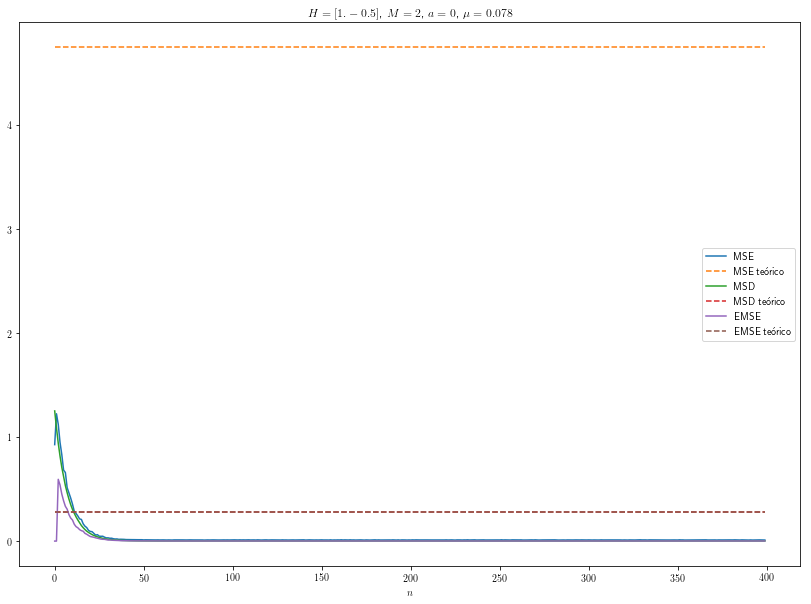

In [3]:
lms_filter, W_o = experiencia_3(item='1', entrada='1', mu=.078, total_time=400, N=1000)
W_o

Coeficientes calculados

In [4]:
lms_filter.W[-1]

array([ 0.96348163, -0.51461728])